# Assignment 1 - Simplified Custom Object Detection

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of object detection: -from loading and inspecting the dataset; -to implementing, training and evaluating a Convolutional Neural Network based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the list of objects provided, please pick at least 3 objects. You may pick more, but less than 3 is not acceptable and results in losing points;
- While we do not require a high performance model, we still expect you to have a model that performs better than "random guessing" (i.e. for 3 objects, mAP should be better than 33%);
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is April 21st Sunday 11:59 PM** (strict, no late submission)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name:**  ZINGA BANDA FIRMINO RENÉ
**Neptun ID:** GAA4QU
**Network:**
**Objects:**

## Task description

Your task is to train your own custom object detection model and compare its performance with an existing object detection model (i.e. YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualizations (matplotlib, seaborn, ...) of the metrics, losses, and predictions. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your network.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [ ]:
!pip install ultralytics

from ultralytics import YOLO

import torch
import torchvision
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

%matplotlib inline

import shutil
import time
import copy
from typing import List

%matplotlib inline
from typing import List
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from IPython.display import Image
from IPython.display import Image, display
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. DATASET
For this assignment you will be using at least 3 of the [Mihály Kolodko's Mini Statues](https://www.atlasobscura.com/places/hidden-mini-statues-of-budapest).

You can find all of the objects seperately in a folder here: [Objects](https://drive.google.com/drive/folders/1QEEHye66USSWesGSVBQw1v1tk3Hr01G9?usp=sharing)

<img src='https://www.goethe.de/resources/files/jpg1201/161kolodkovojenyjkorabel-formatkey-jpg-w1920.jpg' />

#### **1.2. Show some annotations of your dataset**


### 1.1. Load objects



**Please select 3 or more objects.** Upon selecting the objects, **please remove the background, so that only the object is kept**. You can do it manually, online or by code (this is not part of the evaluation of your assignment).
As an example, the following objects have been chosen (the background was removed with Segment Anything Model):

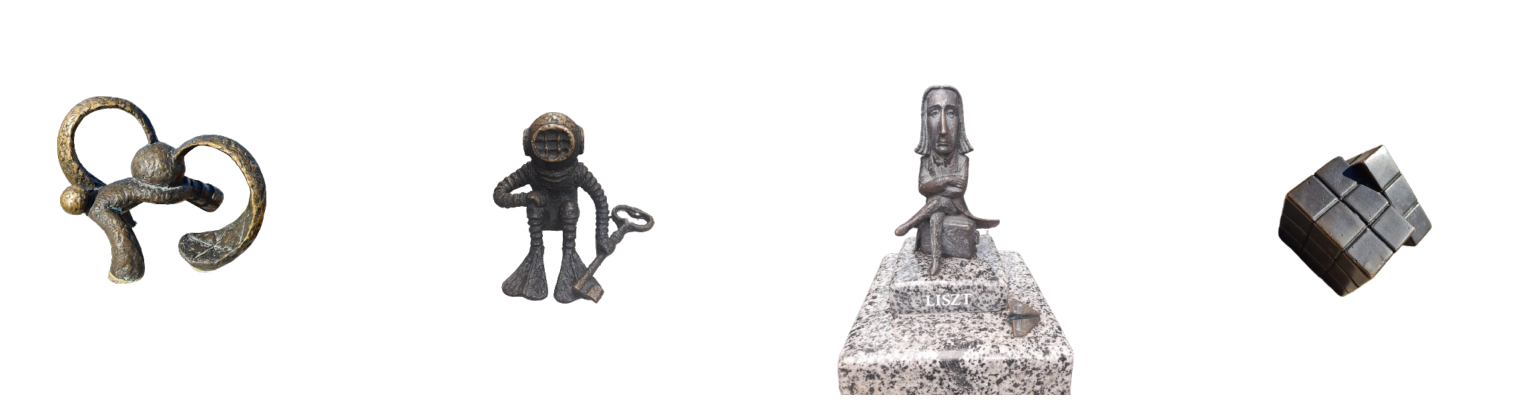

In [ ]:
caminho_imagem1 = "/content/drive/MyDrive/First_DND_Ass.2024/objects/Checkered_Ear_Rabbit.jpg_no_bg.png"
caminho_imagem2 = "/content/drive/MyDrive/First_DND_Ass.2024/objects/Diver.jpg_no_bg.png"
caminho_imagem3 = "/content/drive/MyDrive/First_DND_Ass.2024/objects/Liszt.jpg_no_bg.png"
caminho_imagem4 = "/content/drive/MyDrive/First_DND_Ass.2024/objects/Rubiks_Cube.jpg_no_bg.png"

plt.figure(figsize=(20, 5))

ax1 = plt.subplot(1, 4, 1)
img = mpimg.imread(caminho_imagem1)
ax1.imshow(img)
ax1.axis('off')  # Remover os eixos

ax2 = plt.subplot(1, 4, 2, sharex=ax1, sharey=ax1)
img = mpimg.imread(caminho_imagem2)
ax2.imshow(img)
ax2.axis('off')

ax3 = plt.subplot(1, 4, 3, sharex=ax1, sharey=ax1)
img = mpimg.imread(caminho_imagem3)
ax3.imshow(img)
ax3.axis('off')

ax4 = plt.subplot(1, 4, 4, sharex=ax1, sharey=ax1)
img = mpimg.imread(caminho_imagem4)
ax4.imshow(img)
ax4.axis('off')

plt.show()

#### **1.3. Pre-processing the dataset**

Número de amostras: 336
Amostra 1 - Formato: torch.Size([3, 236, 612])


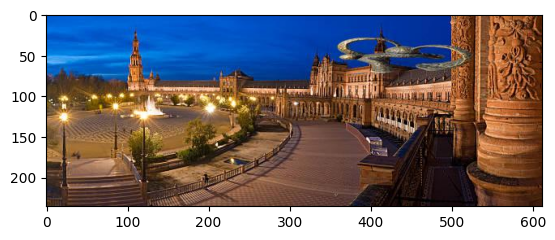

Amostra 2 - Formato: torch.Size([3, 408, 612])


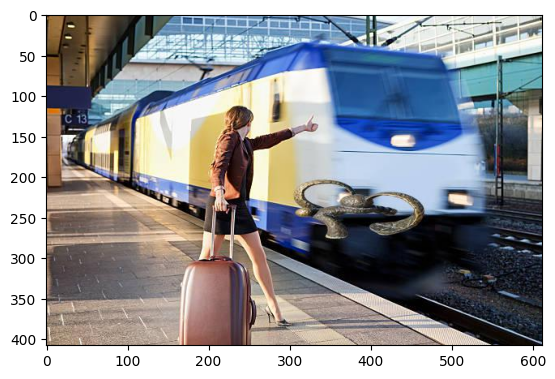

Amostra 3 - Formato: torch.Size([3, 408, 612])


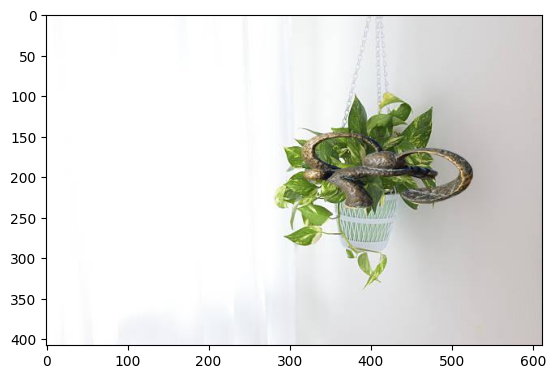

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, root, annotation_file, transform=None):
        self.root = root
        self.transform = transform

        with open(annotation_file, 'r') as f:
            self.img_paths = [line.strip() for line in f]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_paths[idx])
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"O arquivo {img_path} não foi encontrado.")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

img_path = '/content/drive/MyDrive/First_DND_Ass.2024/data'
path_ann = '/content/drive/MyDrive/First_DND_Ass.2024/data/train.txt'

transform = transforms.ToTensor()
custom_dataset = CustomDataset(root=img_path, annotation_file=path_ann, transform=transform)

print(f'Número de amostras: {len(custom_dataset)}')

for i in range(3):
    try:
        image = custom_dataset[i]
        print(f"Amostra {i + 1} - Formato: {image.shape}")
        plt.imshow(image.permute(1, 2, 0))
        plt.show()
    except FileNotFoundError as e:
        print(e)



In [ ]:

class CustomDataset(Dataset):
    def __init__(self, root, annotation_file, transform=None):
        self.root = root
        self.transform = transform

        with open(annotation_file, 'r') as f:
            self.annotations = f.readlines()

        self.class_counts = {}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path, label = self.annotations[idx].strip().split()
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if label in self.class_counts:
            self.class_counts[label] += 2
        else:
            self.class_counts[label] = 1

        return img

path_img = '/content/drive/MyDrive/First_DND_Ass.2024/data'
path_ann = '/content/drive/MyDrive/First_DND_Ass.2024/data/train.txt'

transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

custom_dataset = CustomDataset(root=path_img, annotation_file=path_ann, transform=transform)

print(f'Number of samples: {len(custom_dataset)}')

print('Class Counts:')
for class_label, count in custom_dataset.class_counts.items():
    print(f'Class {class_label}: {count} samples')


Number of samples: 336
Class Counts:


## **2. Models**

#### **2.1. Load the models Yolo**

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import yaml
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os


with open('/content/drive/MyDrive/First_DND_Ass.2024/configy.yaml', 'r') as file:
    config = yaml.safe_load(file)

resize_dims = config['preprocessing']['resize']
mean_values = config['preprocessing']['mean']
std_values = config['preprocessing']['std']
rotation_range = config['preprocessing'].get('rotation', {}).get('degrees', [0, 0])


preprocess = transforms.Compose([
    transforms.Resize(resize_dims),
    transforms.RandomRotation(degrees=rotation_range),  # Rotação configurável
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, std=std_values)
])

class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [name for name in os.listdir(img_dir) if name.endswith('.jpg')]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

train_dataset = CustomDataset(img_dir='/content/drive/MyDrive/First_DND_Ass.2024/data/images/train', transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [ ]:
#!pip install ultralytics
from ultralytics import YOLO

model =YOLO("yolov8n.yaml")

result = model.train(data="/content/drive/MyDrive/First_DND_Ass.2024/configy.yaml",
                     epochs=3
                     )

model.save('/content/drive/MyDrive/First_DND_Ass.2024/model.pt')

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/First_DND_Ass.2024/configy.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning /content/drive/MyDrive/First_DND_Ass.2024/data/labels/train.cache... 335 images, 1 backgrounds, 0 corrupt: 100%|██████████| 336/336 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/First_DND_Ass.2024/data/labels/val.cache... 335 images, 1 backgrounds, 0 corrupt: 100%|██████████| 336/336 [00:00<?, ?it/s]

Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      3.663      5.434      4.227         29        640: 100%|██████████| 21/21 [04:59<00:00, 14.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:20<00:00,  7.35s/it]

                   all        336        335   0.000131     0.0269   7.36e-05   2.78e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      3.463      5.237      4.166         36        640: 100%|██████████| 21/21 [04:54<00:00, 14.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:16<00:00,  6.96s/it]

                   all        336        335   0.000125     0.0269   7.35e-05   2.34e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G       3.18      5.013      4.015         32        640: 100%|██████████| 21/21 [04:52<00:00, 13.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:14<00:00,  6.80s/it]

                   all        336        335   0.000148     0.0328   0.000109    2.5e-05



3 epochs completed in 0.314 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:08<00:00,  6.18s/it]


                   all        336        335   0.000148     0.0328   0.000129   2.69e-05
  Checkered_Ear_Rabbit        336         83    0.00016     0.0361   0.000243   3.26e-05
                 Diver        336         84   5.39e-05     0.0119   2.78e-05   5.52e-06
                 Liszt        336         84   0.000378     0.0833   0.000243   6.96e-05
           Rubiks_Cube        336         84          0          0          0          0
Speed: 1.9ms preprocess, 177.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train2


TypeError: 'NoneType' object is not a mapping

#### **2.1. Load the model**

In [ ]:
import torch

class YOLODataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [name for name in os.listdir(img_dir) if name.endswith('.jpg')]
        self.annotations_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        annotation_path = os.path.join(self.annotations_dir, img_name.replace('.jpg', '.txt'))

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        bboxes = []
        if os.path.exists(annotation_path):
            with open(annotation_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    class_id = int(parts[0])  # Classe

                    bbox = torch.tensor(list(map(float, parts[1:])), dtype=torch.float32)
                    bboxes.append(torch.cat((torch.tensor([class_id], dtype=torch.float32), bbox)))

        if bboxes:
            bboxes = torch.stack(bboxes)
        else:
            bboxes = torch.empty((0, 5))

        return image, bboxes

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = YOLODataset(img_dir='/content/drive/MyDrive/First_DND_Ass.2024/data/obj_train_data', transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

for img, bboxes in loader:
    print(img.shape, bboxes)
    break


torch.Size([4, 3, 640, 640]) tensor([[[0.0000, 0.6897, 0.4787, 0.3558, 0.2542]],

        [[0.0000, 0.6387, 0.7817, 0.2222, 0.1633]],

        [[1.0000, 0.3502, 0.4913, 0.1908, 0.1751]],

        [[2.0000, 0.3929, 0.7750, 0.2963, 0.3013]]])


In [ ]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        # Define custom backbone
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.classifier = nn.Linear(32 * 160 * 160, num_classes)
        self.bbox_regressor = nn.Linear(32 * 160 * 160, 4)

    def forward(self, x):

        x = self.backbone(x)

        x = self.flatten(x)

        class_probs = self.classifier(x)
        bbox_regression = self.bbox_regressor(x)

        return class_probs, bbox_regression

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 4
model = CustomModel(num_classes).to(device)

dummy_image = torch.randn(1, 3, 640, 640).to(device)

cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)

Class Output Shape: torch.Size([1, 4])
Bounding Box Output Shape: torch.Size([1, 4])


In [ ]:
import torch.nn.functional as F

def combined_loss(class_output, bbox_output, true_classes, true_bboxes):
    classification_loss = F.cross_entropy(class_output, true_classes)
    regression_loss = F.smooth_l1_loss(bbox_output, true_bboxes)
    return classification_loss + regression_loss

In [ ]:

def detection_loss(pred_classes, pred_bboxes, true_classes, true_bboxes):

    batch_size, num_boxes = true_classes.shape
    num_classes = pred_classes.shape[-1]
    true_classes_one_hot = F.one_hot(true_classes, num_classes=num_classes).float()
    true_classes_one_hot = true_classes_one_hot.view(-1, num_classes)

    pred_classes = pred_classes.view(-1, num_classes)

    classification_loss = F.binary_cross_entropy_with_logits(pred_classes, true_classes_one_hot, reduction='mean')

    bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')

    return classification_loss + bbox_loss


In [ ]:
def calculate_metrics(output, target):
    """Calcula as métricas de precisão, recall e acurácia."""
    if output.nelement() == 0 or target.nelement() == 0:

        return 0, 0, 0

    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        recall = recall_score(target.cpu(), pred.cpu(), average='macro', zero_division=0)
        precision = precision_score(target.cpu(), pred.cpu(), average='macro', zero_division=0)
        accuracy = accuracy_score(target.cpu(), pred.cpu())

    return recall, precision, accuracy


In [ ]:
for images, bboxes in loader:
    if len(bboxes) == 0:
        continue  # Pula iterações onde não há bounding boxes

    images = images.to(device)
    bboxes = bboxes.to(device)

    true_classes = bboxes[:, :, 0].long()
    true_bboxes = bboxes[:, :, 1:]

    class_output, bbox_output = model(images)
    prob_output = torch.softmax(class_output, dim=1)

    try:
        loss = detection_loss(class_output, bbox_output, true_classes, true_bboxes)
        print("Loss:", loss.item())

        recall, precision, accuracy = calculate_metrics(prob_output, true_classes.squeeze())
        print("Recall:", recall, "Precision:", precision, "Accuracy:", accuracy)
    except Exception as e:
        print("Error computing loss or metrics:", str(e))


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7490204572677612
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.8017204999923706
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.758861780166626
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.781542956829071
Recall: 0.25 Precision: 0.0625 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7699452638626099
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7764372825622559
Recall: 0.25 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7944357395172119
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7704340815544128
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7680877447128296
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7834031581878662
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7607001066207886
Recall: 0.25 Precision: 0.0625 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.738377571105957
Recall: 0.5 Precision: 0.25 Accuracy: 0.5


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.8028838038444519
Recall: 0.25 Precision: 0.0625 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.766080379486084
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7525112628936768
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7987523674964905
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7666487693786621
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7682831287384033
Recall: 0.3333333333333333 Precision: 0.16666666666666666 Accuracy: 0.5


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7458541393280029
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7579684257507324
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7547749280929565
Recall: 0.25 Precision: 0.0625 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7612912654876709
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7695971727371216
Recall: 0.5 Precision: 0.125 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7608686089515686
Recall: 0.3333333333333333 Precision: 0.16666666666666666 Accuracy: 0.5


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7513971328735352
Recall: 0.25 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7603946924209595
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7427886724472046
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7752076387405396
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7697861790657043
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7987816333770752
Recall: 0.3333333333333333 Precision: 0.16666666666666666 Accuracy: 0.5


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7732436656951904
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7942776679992676
Recall: 0.5 Precision: 0.125 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7574684619903564
Recall: 0.25 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7496533393859863
Recall: 0.375 Precision: 0.5 Accuracy: 0.75


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7826105356216431
Recall: 0.5 Precision: 0.25 Accuracy: 0.5


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7474035024642944
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7225323915481567
Recall: 0.5 Precision: 0.125 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7314054369926453
Recall: 0.5 Precision: 0.25 Accuracy: 0.5


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7741888761520386
Recall: 0.1111111111111111 Precision: 0.3333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7932822704315186
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.80113285779953
Recall: 0.5 Precision: 0.375 Accuracy: 0.75


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7854806780815125
Recall: 0.25 Precision: 0.0625 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7929272651672363
Recall: 0.5 Precision: 0.375 Accuracy: 0.75


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.763600766658783
Recall: 0.3333333333333333 Precision: 0.08333333333333333 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.8025022149085999
Recall: 0.5 Precision: 0.25 Accuracy: 0.5


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7372649312019348
Recall: 0.3333333333333333 Precision: 0.16666666666666666 Accuracy: 0.5


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7733184099197388
Recall: 0.0 Precision: 0.0 Accuracy: 0.0


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.762482762336731
Recall: 0.5 Precision: 0.125 Accuracy: 0.25


<ipython-input-103-0932a7145e58>:17: UserWarning: Using a target size (torch.Size([4, 1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  bbox_loss = F.smooth_l1_loss(pred_bboxes, true_bboxes, reduction='mean')


Loss: 0.7593115568161011
Recall: 0.3333333333333333 Precision: 0.2222222222222222 Accuracy: 0.5


RuntimeError: stack expects each tensor to be equal size, but got [1, 5] at entry 0 and [0, 5] at entry 3

In [ ]:
# Exemplo de salvamento de modelo
torch.save(model.state_dict(), '/content/drive/MyDrive/First_DND_Ass.2024/path_to_save_model.pth')

# Carregar modelo
model.load_state_dict(torch.load('/content/drive/MyDrive/First_DND_Ass.2024/path_to_save_model.pth'))
model.eval()  # Colocar o modelo em modo de avaliação quando for fazer inferências



CustomModel(
  (backbone): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=819200, out_features=4, bias=True)
  (bbox_regressor): Linear(in_features=819200, out_features=4, bias=True)
)

## 4. **Visualize results**

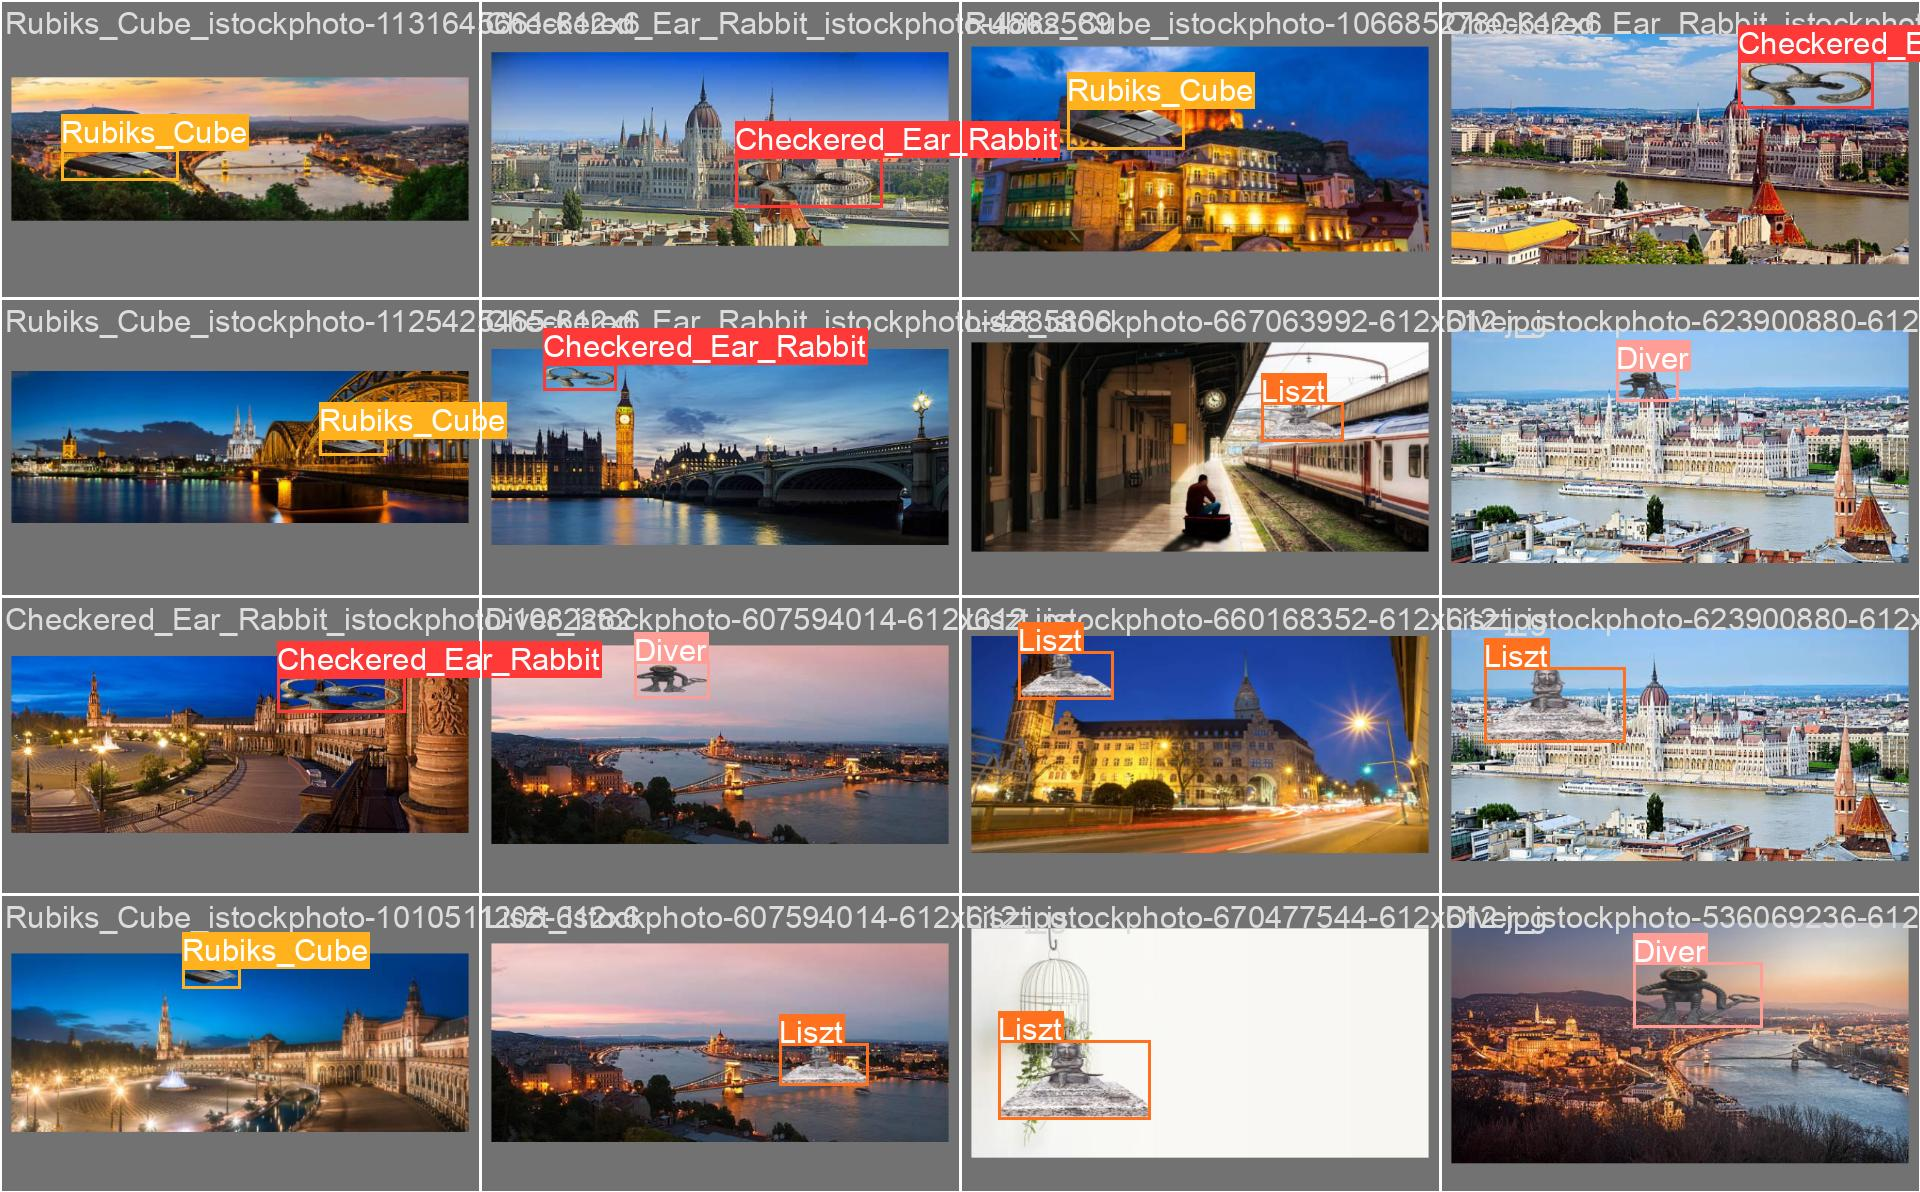

In [ ]:
image_path = '/content/drive/MyDrive/First_DND_Ass.2024/train2/val_batch0_labels.jpg'
display(Image(filename=image_path, width=800))

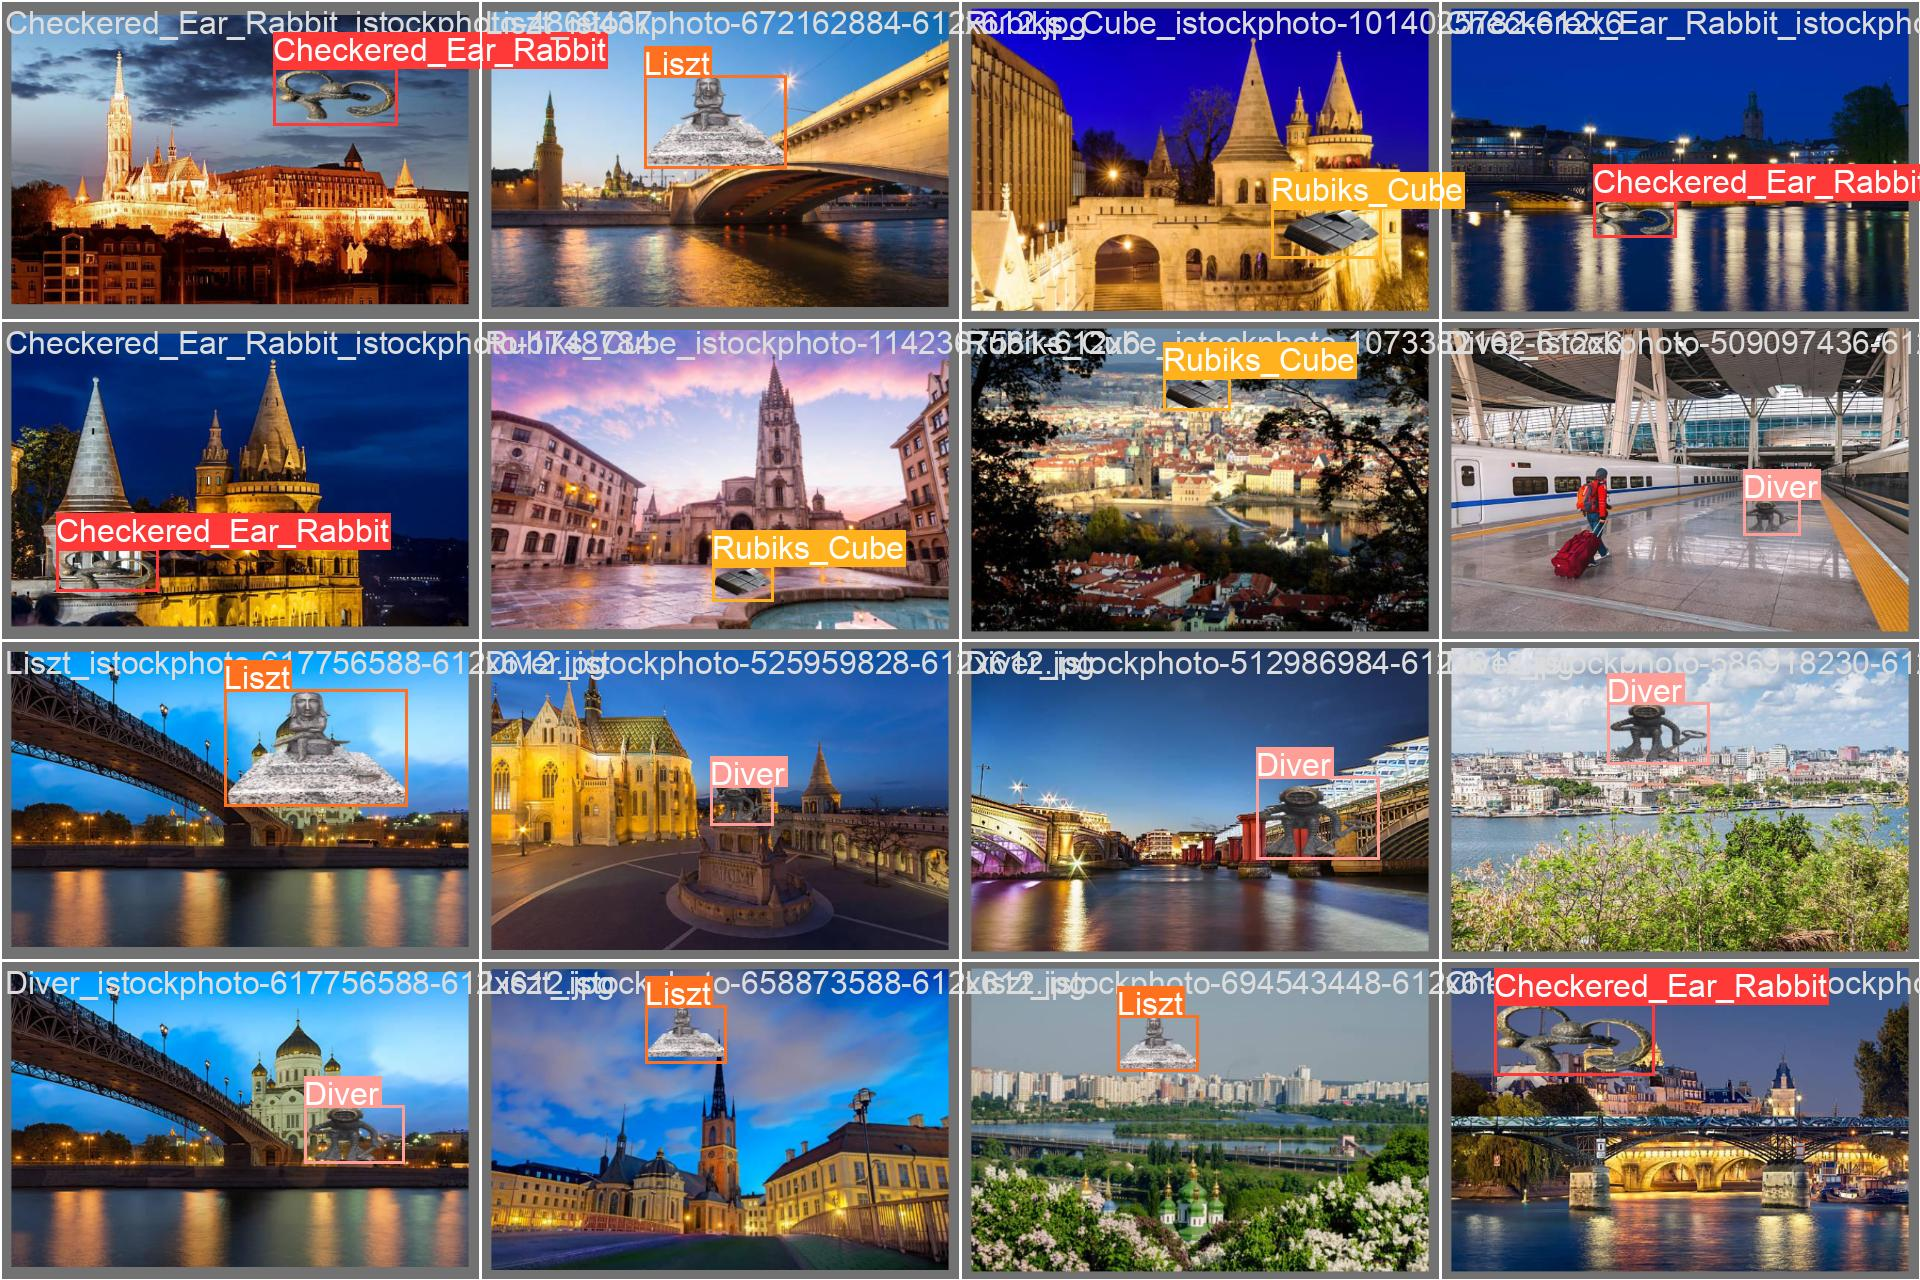

In [ ]:
image_path = '/content/drive/MyDrive/First_DND_Ass.2024/train2/val_batch1_labels.jpg'
display(Image(filename=image_path, width=800))

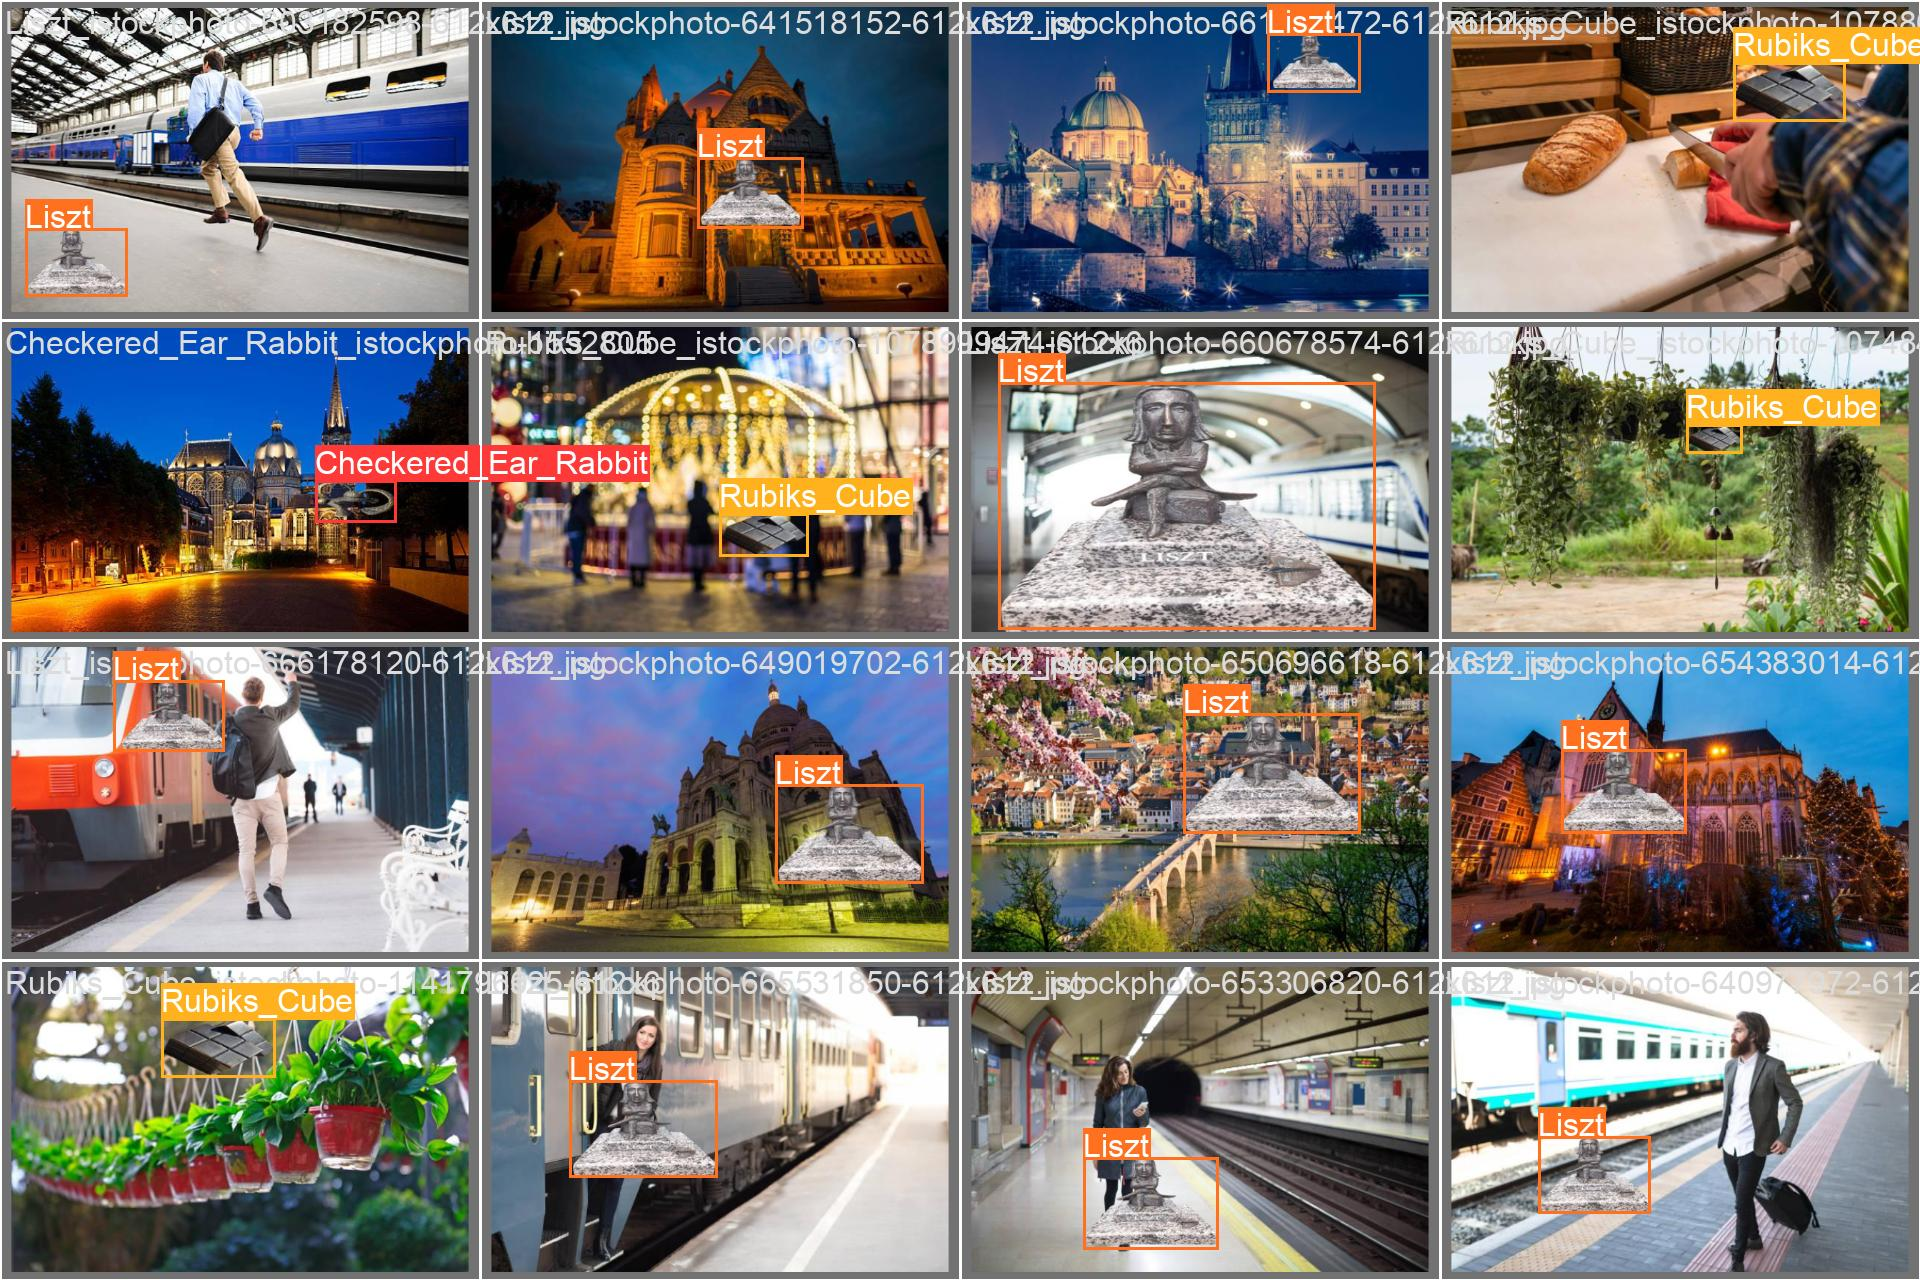

In [ ]:
image_path = '/content/drive/MyDrive/First_DND_Ass.2024/train2/val_batch2_labels.jpg'
display(Image(filename=image_path, width=800))


**4.2. Training results**

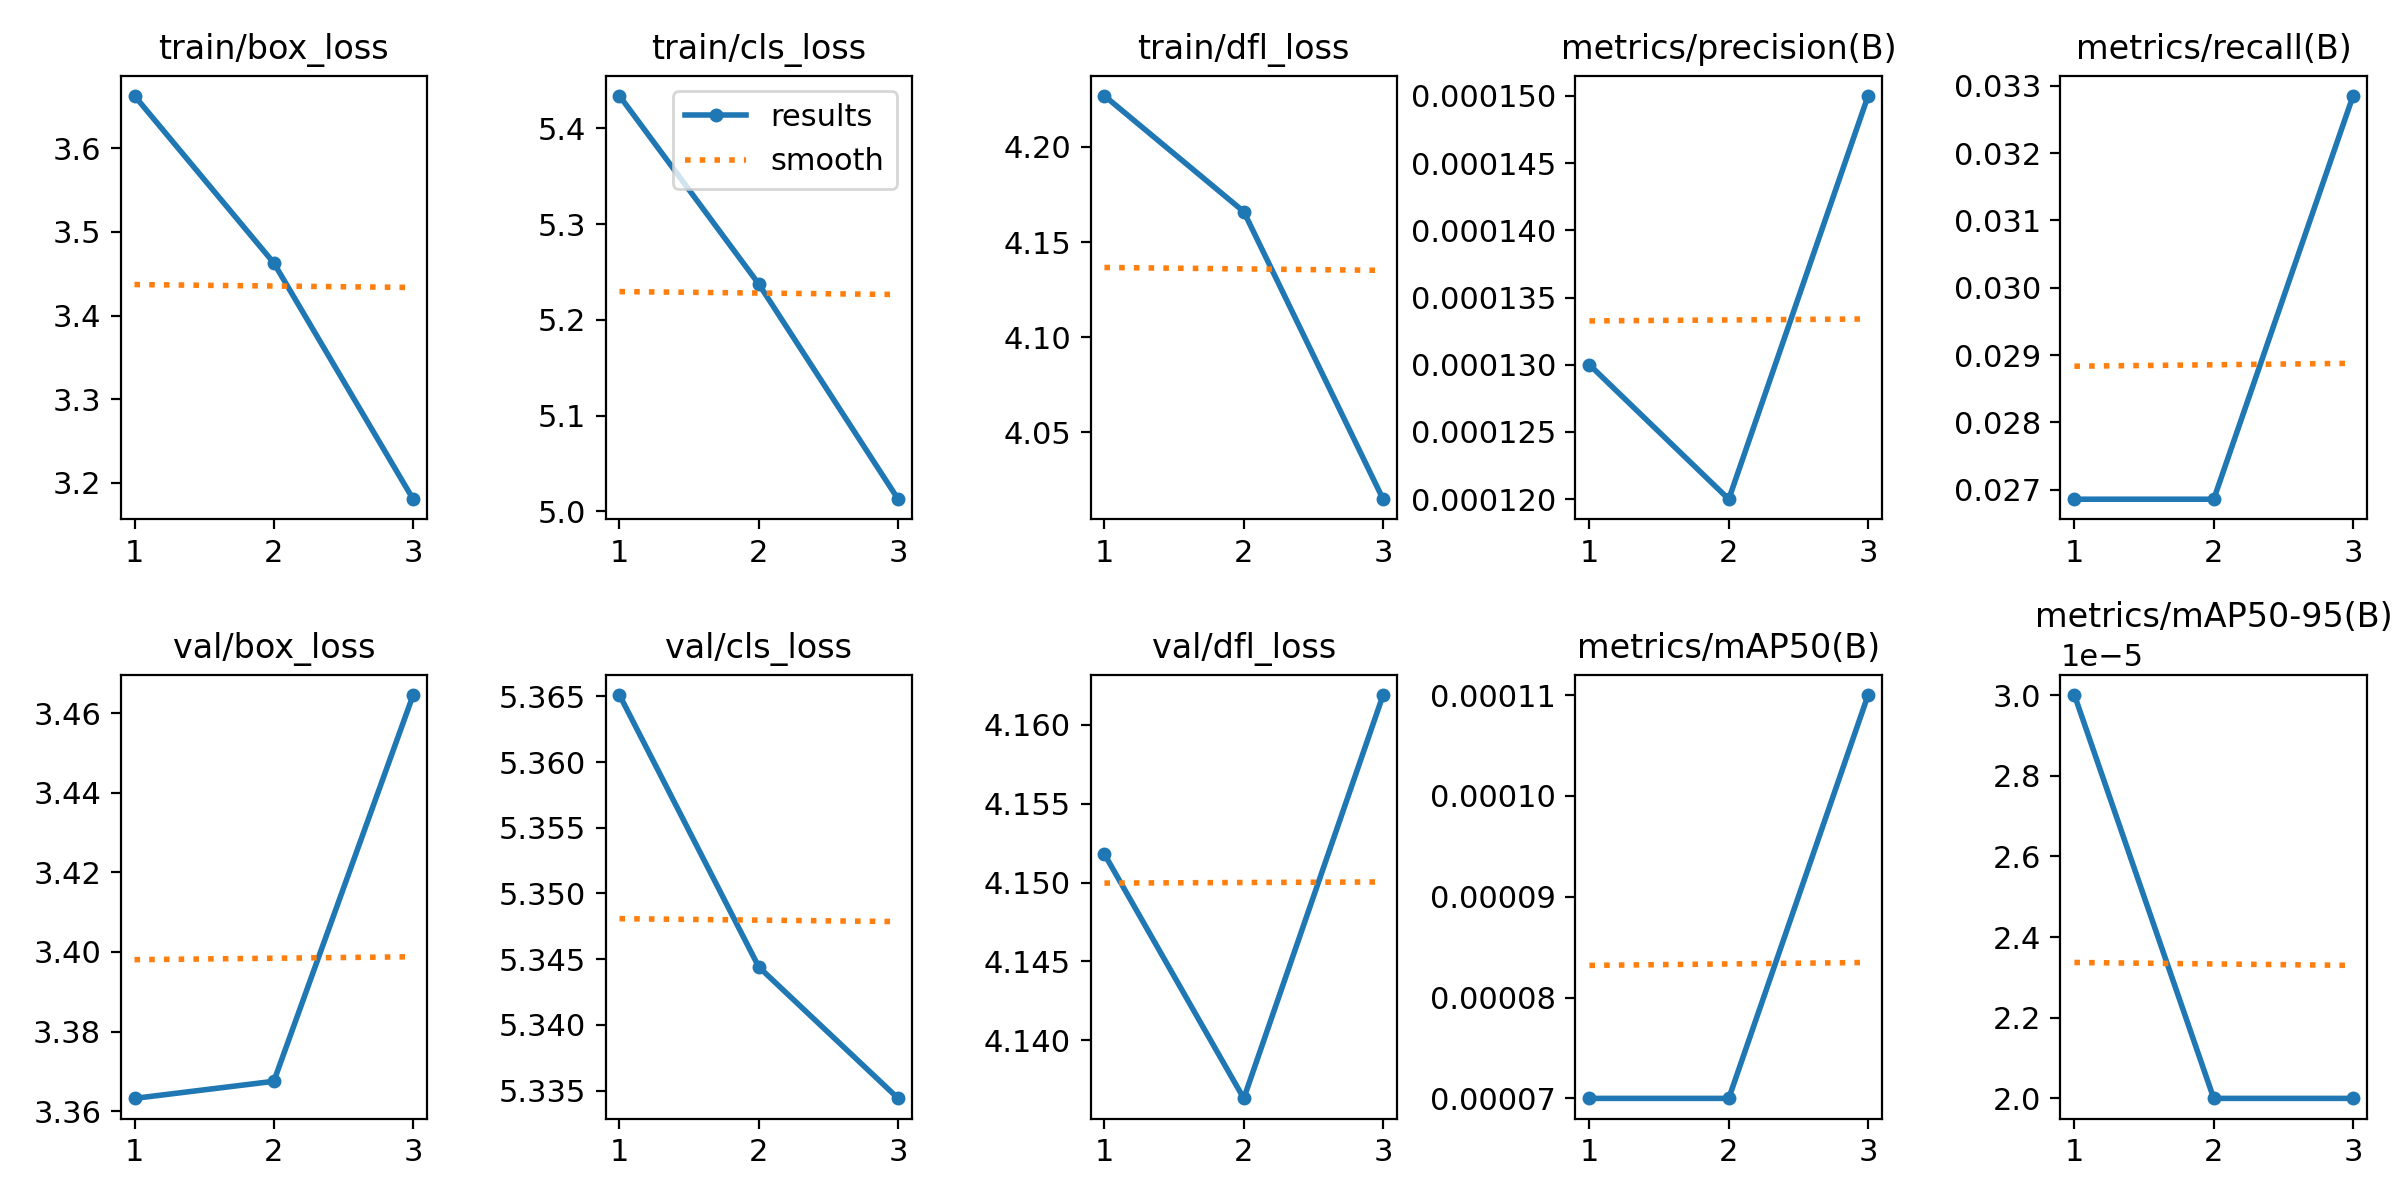

In [ ]:
image_path = '/content/drive/MyDrive/First_DND_Ass.2024/train2/results.png'
display(Image(filename=image_path, width=800))

In [1]:
image_path = '/content/drive/MyDrive/First_DND_Ass.2024/train2/val_batch2_pred.jpg'
display(Image(filename=image_path, width=800))

NameError: name 'Image' is not defined